# Imports

In [2]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pytorch_fid import fid_score
from torchvision.utils import save_image
import torch.nn.functional as F
import torchvision.utils as vutils
import random

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


# Parameters

In [3]:
# Root directory for dataset
dataroot = "/home/sriyar/adrl_assignment1/Animals_data/animals/animals"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 128

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 64 

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lrd = 0.00005
lrg = 0.00005

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Data loading and preprocessing

Shape of real_batch: torch.Size([64, 3, 128, 128])
Range of grid values: 0.0 1.0


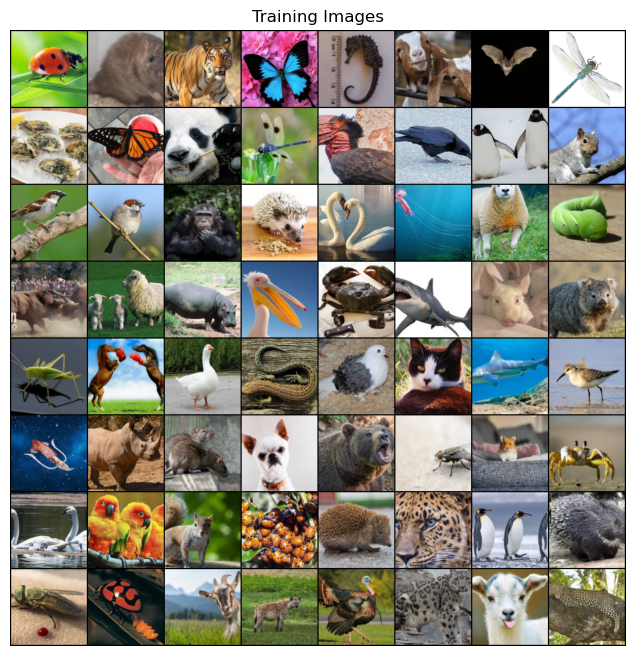

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:2" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
# Assuming real_batch is defined and properly set
real_batch = real_batch[0].to(device)  # Move to GPU if needed

# Check the shape of the batch
print("Shape of real_batch:", real_batch.shape)  # Should be [128, 3, 128, 128]

# Make sure to take the first 64 images
grid = vutils.make_grid(real_batch[:64], padding=2, normalize=True)

# Transpose the grid to (channels, height, width) -> (height, width, channels) for plt.imshow
grid = grid.cpu()  # Ensure the grid is on CPU for plotting
grid = np.transpose(grid.numpy(), (1, 2, 0))  # Convert to numpy and transpose

# Check the range of the grid
print("Range of grid values:", grid.min(), grid.max())

# Plotting the images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(grid)  # Plot the grid
plt.show()


# Weight initialization 

In [5]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator class

In [6]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),            
            
            nn.ConvTranspose2d( ngf * 2, ngf , 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ba

Discriminator Code


# Discriminator class

In [8]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),  # Output: (ndf) x 64 x 64
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # Output: (ndf*2) x 32 x 32
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # Output: (ndf*4) x 16 x 16
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # Output: (ndf*8) x 8 x 8
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),  # Output: (1) x 5 x 5
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (1) x 5 x 5
            nn.Conv2d(1, 1, 5, 1, 0, bias=False),  # Output: (1) x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


Now, as with the generator, we can create the discriminator, apply the
`weights_init` function, and print the model's structure.


In [9]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
  

# Loss and optimizers

In [10]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.RMSprop(netD.parameters(), lr=lrd)
optimizerG = optim.RMSprop(netG.parameters(), lr=lrg)


# FID code

In [ ]:

def calculate_fid(netG):
    real_idx = 0
    gen_idx = 0
    eps = 1e-10  
    resize_transform = transforms.Compose([
        transforms.Resize((299, 299)) 
    ])
        
    real_img_dir = 'real_images_animals'
    gen_img_dir = 'generated_images_animals'
    os.makedirs(real_img_dir, exist_ok=True)
    os.makedirs(gen_img_dir, exist_ok=True)

    def save_images(images, directory, prefix, start_idx):
        os.makedirs(directory, exist_ok=True)
        for i, img in enumerate(images):
            save_image(img, os.path.join(directory, f"{prefix}_{start_idx + i}.png"))

    for image,_ in dataloader:
        real_images = image.to(device).cpu()
        if real_idx < 1000:  
            for idx, img in enumerate(real_images): 
                min_val = img.min()
                max_val = img.max()
                normalized_img = (img - min_val) / (max_val - min_val + eps)
                resized_img = resize_transform(normalized_img)
                save_images(resized_img, real_img_dir, "real", real_idx+idx)
                    
            real_idx += real_images.shape[0]
        if gen_idx < 1000:
            z = torch.randn(128, nz, 1, 1, device=device)
            generated_imgs = netG(z).cpu()
                    
            for idx, img in enumerate(generated_imgs):
                min_val = img.min()
                max_val = img.max()
                normalized_img = (img - min_val) / (max_val - min_val + eps)
                resized_img = resize_transform(normalized_img)
                save_images(resized_img, gen_img_dir, "gen", gen_idx+idx)
            gen_idx += real_images.shape[0]
            break

    # Compute FID
    fid_value = fid_score.calculate_fid_given_paths([real_img_dir, gen_img_dir], batch_size=64, device=device, dims=2048)
    return fid_value

# Training for DC-GAN

In [12]:
# Training Loop with k discriminator updates per epoch
torch.use_deterministic_algorithms(False)

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
fid_scores = []
iters = 0
import os
k = 5 
# Function to save checkpoints
def save_checkpoint(epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, fid_scores, iters, k, path='./checkpoint_dcgan_animals_k5.pth'):
    state = {
        'epoch': epoch,
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'G_losses': G_losses,
        'D_losses': D_losses,
        'fid_scores': fid_scores,
        'iters': iters,
        'k': k  # Store the number of discriminator updates per epoch
    }
    torch.save(state, path)
    print(f'Checkpoint saved at epoch {epoch}, iteration {iters}, k={k}')

# Function to load checkpoints
def load_checkpoint(netG, netD, optimizerG, optimizerD, path='./checkpoint_dcgan_animals_k5.pth'):
    if os.path.exists(path):
        state = torch.load(path)
        netG.load_state_dict(state['netG_state_dict'])
        netD.load_state_dict(state['netD_state_dict'])
        optimizerG.load_state_dict(state['optimizerG_state_dict'])
        optimizerD.load_state_dict(state['optimizerD_state_dict'])
        epoch = state['epoch']
        G_losses = state['G_losses']
        D_losses = state['D_losses']
        fid_scores = state['fid_scores']
        iters = state['iters']
        k = state.get('k', 1)  # Load k; default to 1 if not found
        print(f'Checkpoint loaded from epoch {epoch}, iteration {iters}, k={k}')
        return epoch, G_losses, D_losses, fid_scores, iters, k
    else:
        print('No checkpoint found, starting from scratch.')
        return 0, [], [], [], 0, 5  # Start from epoch 0 and k=1 if no checkpoint is found

# Load the latest checkpoint (if available)
start_epoch, G_losses, D_losses, fid_scores, iters, k = load_checkpoint(netG, netD, optimizerG, optimizerD)



# Training Loop
torch.use_deterministic_algorithms(False)

print("Starting Training Loop...")
for epoch in range(start_epoch, num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        # Update D network k times for each update of G network
        for _ in range(k):
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            netD.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            output = netD(real_cpu).view(b_size)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

        # (2) Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
        iters += 1

    # Calculate FID after each epoch
    with torch.no_grad():
        real_images = next(iter(dataloader))[0][:1000]
        fake_images = netG(fixed_noise).detach()
        fid_value = calculate_fid(real_images, fake_images)
        fid_scores.append(fid_value)
        print(f'Epoch [{epoch}/{num_epochs}], FID: {fid_value:.4f}')
    
    # Save checkpoint after each epoch
    save_checkpoint(epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, fid_scores, iters, k)


/tmp/ipykernel_242021/4157727476.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path)


Checkpoint loaded from epoch 99, iteration 8500, k=5
Starting Training Loop...


[99/100][0/85]	Loss_D: 0.0163	Loss_G: 5.4022	D(x): 0.9928	D(G(z)): 0.0089 / 0.0074
[99/100][50/85]	Loss_D: 0.0058	Loss_G: 6.2176	D(x): 0.9969	D(G(z)): 0.0027 / 0.0027


/home/sriyar/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sriyar/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [99/100], FID: 15186.7111
Checkpoint saved at epoch 99, iteration 8585, k=5


In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Loss plot for K=1
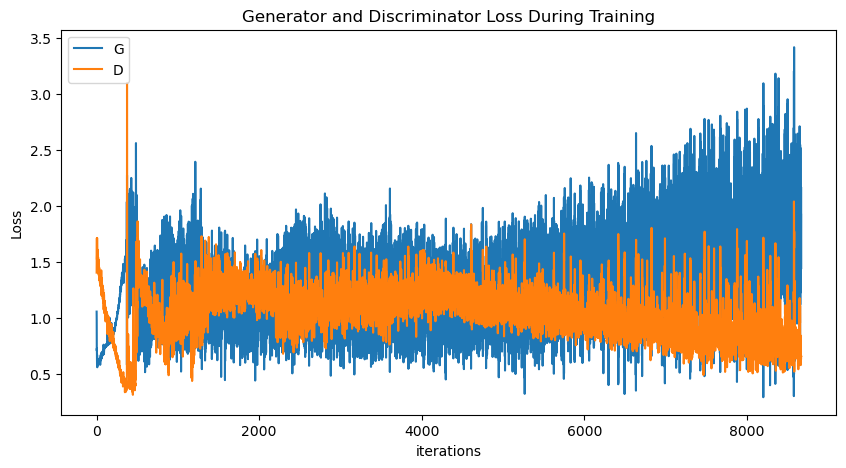

## Loss plot for K=5
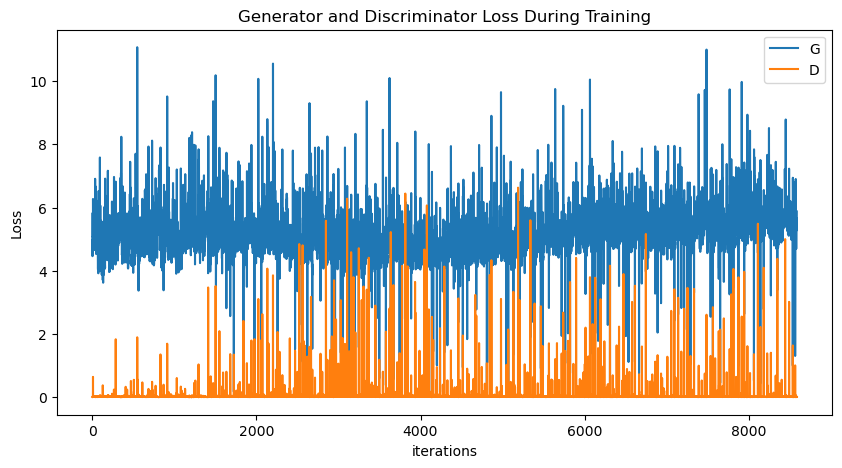

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:100], padding=5, normalize=True).cpu(), (1, 2, 0)))

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1][:100], padding=5, normalize=True), (1, 2, 0)))

plt.show()
